Shape dataset (6409, 11)
means:  Close           8.036797e+01
Volume          1.087093e+06
MarketCap       1.954685e+10
Weight          6.289315e-03
Return          4.417263e-04
LogReturn       1.723115e-04
WeightedRet     4.306955e-06
SMA20           8.029539e+01
EMA20           8.029467e+01
RSI14           5.211280e+01
ReturnVola20    2.049862e-02
dtype: float64
stds:  Close           7.186329e+01
Volume          9.459844e+05
MarketCap       1.747837e+10
Weight          3.087590e-03
Return          2.315582e-02
LogReturn       2.325378e-02
WeightedRet     1.423583e-04
SMA20           7.175884e+01
EMA20           7.168856e+01
RSI14           1.325365e+01
ReturnVola20    1.071267e-02
dtype: float64


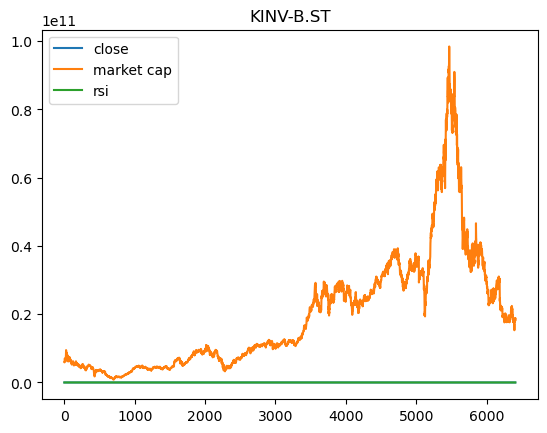

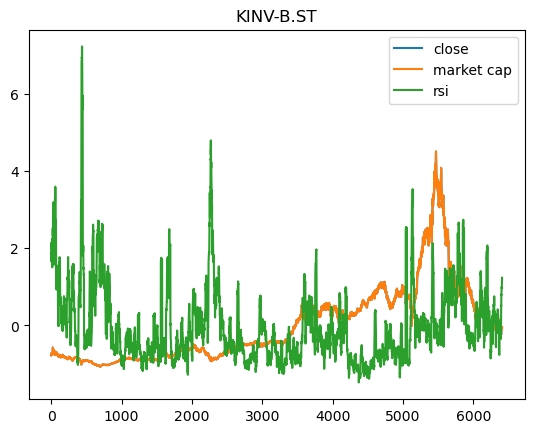

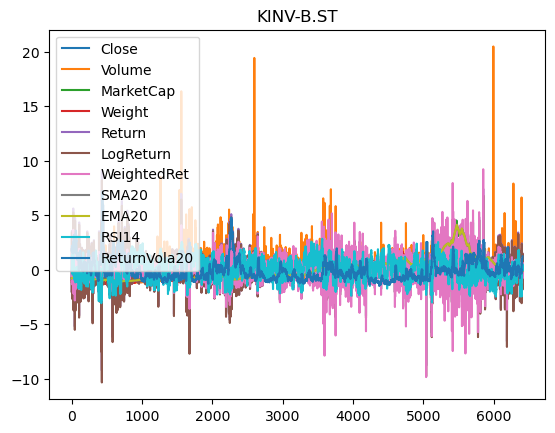

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv(
    "OMXS22_raw_features.csv",
    parse_dates=["Date"],
    index_col="Date"
)


feature_cols = ["Close","Volume",
                "MarketCap","Weight",
                "Return","LogReturn","WeightedRet",
                "SMA20","EMA20","RSI14","ReturnVola20"]

chosen_ticker = "KINV-B.ST"

def retrive_data_values(df, feature_cols, chosen_ticker):
    volvo_df = df[df["Ticker"] == chosen_ticker]
    volvo_df = volvo_df.iloc[20:]

    volvo_prices = volvo_df["Close"].values    
    volvo_market_cap = volvo_df["MarketCap"].values
    volvo_rsi = volvo_df["RSI14"].values

    volvo_dataset = volvo_df[feature_cols]
    print('Shape dataset', volvo_dataset.shape)

    volvo_values = volvo_dataset.values

    means = volvo_dataset.mean(axis=0)
    stds = volvo_dataset.std(axis=0)

    print('means: ',means)
    print('stds: ', stds)

    volvo_dataset_norm = (volvo_dataset - means)/stds 
    volvo_values_norm = volvo_dataset_norm.values

    norm_close = volvo_values_norm[:,0]
    norm_mark_cap = volvo_values_norm[:,2]
    norm_rsi = volvo_values_norm[:, 10]

    plt.plot(volvo_prices, label= 'close')
    plt.plot(volvo_market_cap, label='market cap')
    plt.plot(volvo_rsi, label='rsi')
    plt.legend()
    plt.title(chosen_ticker)
    plt.show()

    plt.plot(norm_close, label= 'close')
    plt.plot(norm_mark_cap, label='market cap')
    plt.plot(norm_rsi, label='rsi')
    plt.legend()
    plt.title(chosen_ticker)

    plt.show()

    for i in range(len(feature_cols)):
        plt.plot(volvo_values_norm[:,i], label= feature_cols[i])

    plt.legend()
    plt.title(chosen_ticker)

    return volvo_values, volvo_dataset


data_values, dataframe = retrive_data_values(df=df, feature_cols=feature_cols, chosen_ticker=chosen_ticker)

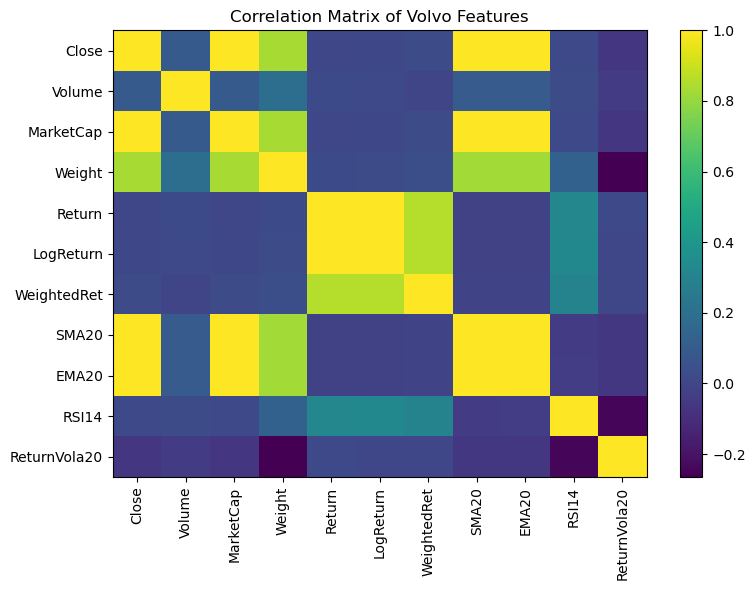

In [42]:
corr = dataframe.corr()
plt.figure(figsize=(8, 6))
im = plt.imshow(corr, aspect='auto')
plt.colorbar(im)
plt.xticks(ticks=np.arange(len(feature_cols)), labels=feature_cols, rotation=90)
plt.yticks(ticks=np.arange(len(feature_cols)), labels=feature_cols)
plt.title("Correlation Matrix of Volvo Features")
plt.tight_layout()
plt.show()


In [43]:
import deeptrack as dt
import torch
from torch.utils.data import DataLoader

In [95]:
data_values = data_values
window_step_length = 50
window_size = 100
num_test_points = 200

horizon = 5
target_idx = 0

n_features = data_values.shape[1]

In [96]:
def generate_loaders_and_benchmark(raw_numpy_data, window_step_length, num_test_points, window_size, horizon, target_idx):

    data = raw_numpy_data[:-num_test_points]
    test_real_data = raw_numpy_data[-num_test_points:]
    #print(data[-1])
    #print(test_real_data[0])
    plt.plot(test_real_data[:,0])
    plt.title('Test data plot')
    plt.show()

    n_samples = data.shape[0]
    past_seq = window_size
    lag = 1

    in_sequences, targets = [], []
    for i in range(past_seq, n_samples - lag, window_step_length):
        in_sequences.append(data[i - past_seq:i, :])
        targets.append(data[i + lag:i + lag + 1, target_idx])
    in_sequences, targets = np.asarray(in_sequences), np.asarray(targets)
    #print(targets[10:])

    print('in sequences shape: ',in_sequences.shape)
    print('targets shape: ',targets.shape)

    sources = dt.sources.Source(inputs=in_sequences, targets=targets)
    train_sources, val_sources = dt.sources.random_split(sources, [0.8, 0.2])

    

    train_mean = np.mean([src["inputs"] for src in train_sources], axis=(0, 1))
    train_std = np.std([src["inputs"] for src in train_sources], axis=(0, 1))

    inputs_pipeline = (dt.Value(sources.inputs - train_mean) / train_std
                       >> dt.pytorch.ToTensor(dtype=torch.float))
    targets_pipeline = (dt.Value(sources.targets - train_mean[target_idx]) 
                        / train_std[target_idx])

    train_dataset = dt.pytorch.Dataset(inputs_pipeline & targets_pipeline,
                                       inputs=train_sources)
    val_dataset = dt.pytorch.Dataset(inputs_pipeline & targets_pipeline,
                                     inputs=val_sources)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    #for x, y in val_loader:
    #    print(x)
    #    print(y)
    #    break

    temperature = data[:, target_idx]
    benchmark_celsius = np.mean(
        np.abs(
            temperature[window_step_length + lag::window_step_length]
            - temperature[lag:-(window_step_length - lag):window_step_length]
        )
    )
    benchmark = benchmark_celsius / train_std[target_idx]

    print(f"Benchmark Celsius: {benchmark_celsius}")
    print(f"Normalized Benchmark: {benchmark}")

    return train_loader, val_loader, benchmark

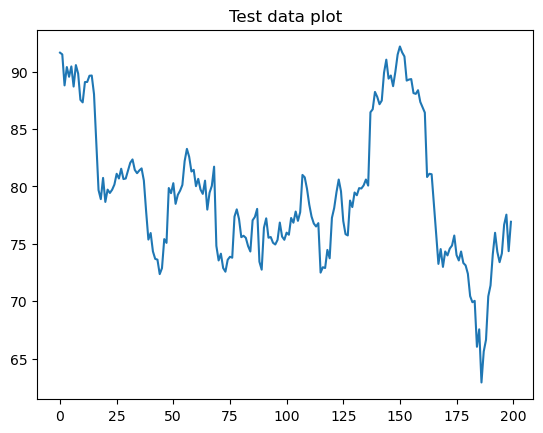

in sequences shape:  (123, 100, 11)
targets shape:  (123, 1)
Benchmark Celsius: 9.155009704251443
Normalized Benchmark: 0.12367097099282325


In [97]:
train_loader, val_loader, benchmark = generate_loaders_and_benchmark(raw_numpy_data=data_values, 
                                                                     window_step_length=window_step_length,
                                                                     window_size=window_size,
                                                                     num_test_points=num_test_points,
                                                                     horizon=horizon,
                                                                     target_idx=target_idx
                                                                     )

In [98]:
def get_device():
    """Select device where to perform the computations."""
    if torch.cuda.is_available():
        return torch.device("cuda:0")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")
    
device = get_device()
print(device)

cuda:0


In [99]:
def plot_training(epochs, train_losses, val_losses, benchmark):
    """Plot the training and validation losses."""
    plt.plot(range(epochs), train_losses, label="Training Loss")
    plt.plot(range(epochs), val_losses, "--", label="Validation Loss")
    plt.plot([0, epochs - 1], [benchmark, benchmark], ":k", label="Benchmark")
    plt.xlabel("Epoch")
    plt.xlim([0, epochs - 1])
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    

In [100]:
epochs = 100

INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | L1Loss           | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | RecurrentModel   | 252 K  | train
5 | optimizer     | Adam             | 0      | train
-----------------------------------------------------------
252 K     Trainable params
0         Non-trainable params
252 K     Total params
1.010     Total estimated model params size (MB)
23        Modules in train mode
1         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | L1Loss           | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollec

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

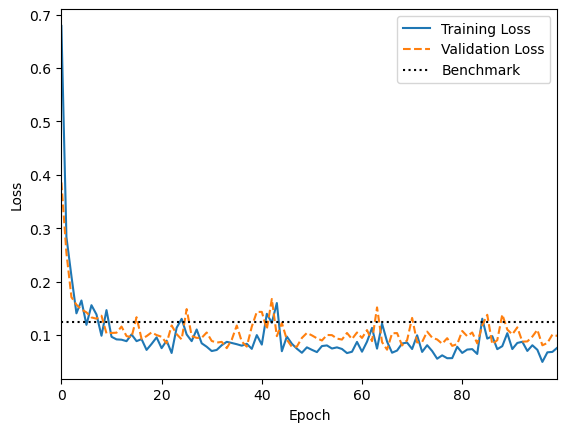

In [101]:
import deeplay as dl

gru_dl = dl.RecurrentModel(
    in_features=n_features,
    hidden_features=[128, 128, 128],
    out_features=1,
    rnn_type="GRU",
    dropout=0.2,
)
gru_stacked = dl.Regressor(gru_dl, optimizer=dl.Adam(lr=0.001)).create()

trainer = dl.Trainer(max_epochs=epochs, accelerator="auto")
trainer.fit(gru_stacked, train_loader, val_loader)

train_losses = trainer.history.history["train_loss_epoch"]["value"]
val_losses = trainer.history.history["val_loss_epoch"]["value"][1:]
plot_training(epochs, train_losses, val_losses, benchmark)

In [102]:
import torch.nn as nn
class CrossAttentionGRUV1(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_hidden_layers, out_dim, dropout, num_heads):
        super().__init__()
        self.gru_model = nn.GRU(in_dim, hidden_dim, num_layers=num_hidden_layers, dropout=dropout, batch_first=True)
        self.input_proj = nn.Linear(in_dim, hidden_dim)
        self.cross_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, kdim=hidden_dim, vdim=hidden_dim, dropout=0, batch_first=True)
        self.fuse_fc = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU()
        )
        self.fc = nn.Linear(hidden_dim, out_dim)
        self._stored_attn_weights = None

    def get_attn_weights(self):
        return self._stored_attn_weights

    def forward(self, x):
        gru_out, _ = self.gru_model(x)

        x_proj = self.input_proj(x)

        cross_attn_out, cross_attn_weights = self.cross_attn(query=gru_out, key=x_proj, value=x_proj)

        self._stored_attn_weights = cross_attn_weights.detach()
        #print('gru:', gru_out)
        #print('cross attn: ', cross_attn_out)

        combined = cross_attn_out+gru_out
        #fused = self.fuse_fc(combined)
        #print(combined.shape)

        final_step = combined[:, -1, :]
        #print(final_step.shape)

        output = self.fc(final_step)

        return output

In [103]:
class CrossAttentionGRUV2(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_hidden_layers, out_dim, dropout, num_heads):
        super().__init__()
        self.gru_model = nn.GRU(in_dim, hidden_dim, num_layers=num_hidden_layers, dropout=dropout, batch_first=True)
        self.input_proj = nn.Linear(in_dim, hidden_dim)
        self.cross_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, kdim=in_dim, vdim=in_dim, dropout=0, batch_first=True)
        self.fuse_fc = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU()
        )
        self.fc = nn.Linear(hidden_dim, out_dim)
        self._stored_attn_weights = None

    def get_attn_weights(self):
        return self._stored_attn_weights

    def forward(self, x):
        gru_out, _ = self.gru_model(x)

        x_proj = x #self.input_proj(x)

        cross_attn_out, cross_attn_weights = self.cross_attn(query=gru_out, key=x_proj, value=x_proj)

        self._stored_attn_weights = cross_attn_weights.detach()
        #print('gru:', gru_out)
        #print('cross attn: ', cross_attn_out)

        combined = torch.cat([gru_out, cross_attn_out], dim=-1)
        fused = self.fuse_fc(combined)
        #print(combined.shape)

        final_step = fused[:, -1, :]
        #print(final_step.shape)

        output = self.fc(final_step)

        return output

INFO: 
  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | loss          | L1Loss              | 0      | eval 
1 | train_metrics | MetricCollection    | 0      | train
2 | val_metrics   | MetricCollection    | 0      | train
3 | test_metrics  | MetricCollection    | 0      | train
4 | model         | CrossAttentionGRUV1 | 445 K  | train
5 | optimizer     | Adam                | 0      | train
--------------------------------------------------------------
445 K     Trainable params
0         Non-trainable params
445 K     Total params
1.782     Total estimated model params size (MB)
13        Modules in train mode
1         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | loss          | L1Loss              | 0      | eval 
1 | train_metrics | MetricCollection    | 0      |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

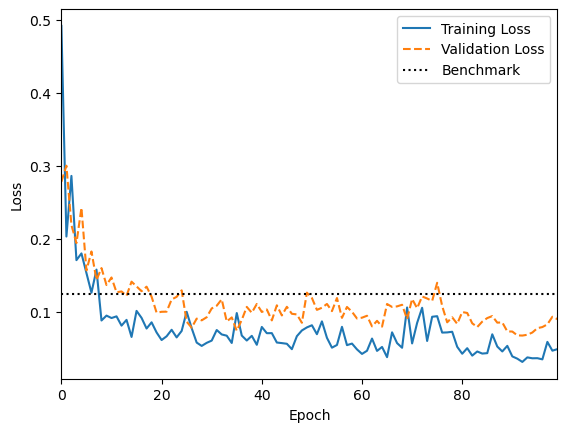

In [104]:


cross_attention_gru_model = CrossAttentionGRUV1(in_dim=n_features, hidden_dim=144, num_hidden_layers=3, out_dim=1, dropout=0.1, num_heads=24)

cross_attention_gru_reg = dl.Regressor(cross_attention_gru_model, optimizer=dl.Adam(lr=0.001)).create()

trainer_cross_gru = dl.Trainer(max_epochs=epochs, accelerator="auto")
trainer_cross_gru.fit(cross_attention_gru_reg, train_loader, val_loader)

train_losses = trainer_cross_gru.history.history["train_loss_epoch"]["value"]
val_losses = trainer_cross_gru.history.history["val_loss_epoch"]["value"][1:]
plot_training(epochs, train_losses, val_losses, benchmark)

In [105]:
def test_model_output(model, data_loader, num_tests=20):
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            x_batch, y_batch = batch
            #print(y_batch)
            test_prediction = model(x_batch)
            
            break

    print("Last 10 timesteps (input) and true vs predicted temperature:")
    for i in range(num_tests):
        
        last_input_temp = x_batch[i, -1, 1].item()  
        true_temp = y_batch[i].item()
        predicted_temp = test_prediction[i].item()

        print(f"Sample {i+1}: Last input temp = {last_input_temp:.2f}, True = {true_temp:.2f}, Pred = {predicted_temp:.2f}")

In [106]:
test_model_output(cross_attention_gru_reg, val_loader)
test_model_output(gru_stacked, val_loader)

Last 10 timesteps (input) and true vs predicted temperature:
Sample 1: Last input temp = 0.09, True = -0.53, Pred = -0.51
Sample 2: Last input temp = 0.87, True = 1.60, Pred = 1.54
Sample 3: Last input temp = -0.43, True = 0.63, Pred = 0.65
Sample 4: Last input temp = 1.40, True = 0.23, Pred = 0.23
Sample 5: Last input temp = 0.14, True = 0.31, Pred = 0.33
Sample 6: Last input temp = 1.45, True = 0.29, Pred = 0.32
Sample 7: Last input temp = 0.15, True = 0.17, Pred = 0.26
Sample 8: Last input temp = -0.29, True = 0.15, Pred = 0.17
Sample 9: Last input temp = -0.52, True = -0.83, Pred = -0.78
Sample 10: Last input temp = -0.30, True = -0.86, Pred = -0.80
Sample 11: Last input temp = 0.46, True = -0.59, Pred = -0.52
Sample 12: Last input temp = -0.33, True = 0.87, Pred = 1.13
Sample 13: Last input temp = 0.18, True = 0.55, Pred = 0.48
Sample 14: Last input temp = -0.16, True = -0.67, Pred = -0.64
Sample 15: Last input temp = -1.12, True = -0.80, Pred = -0.77
Sample 16: Last input temp = 

In [107]:
def generate_predictions(model, window_size, real_data, num_of_future_predictions):
    model.eval()

    train_mean = real_data.mean(axis=0)
    train_std = real_data.std(axis=0)
    train_mean_torch = torch.tensor(train_mean, dtype=torch.float32)
    train_std_torch = torch.tensor(train_std, dtype=torch.float32)
    #print(train_mean_torch)
    #print(train_std_torch)


    last_window = torch.tensor(real_data[-window_size-num_of_future_predictions:], dtype=torch.float32)
    last_window = (last_window - train_mean_torch ) / train_std_torch
    #print(last_window.shape)
    #print(last_window)

    test_real_data_torch = torch.tensor(real_data[-num_of_future_predictions:], dtype=torch.float32)


    test_real_data_torch = (test_real_data_torch - train_mean_torch)/ train_std_torch
    print('test data shape', test_real_data_torch.shape)

    #print(test_real_data_torch)

    preds_norm = []

    with torch.no_grad():
        for t in range(num_test_points):
            x_in  = last_window.unsqueeze(0)
            pred_torch = model(x_in)
            #print('pred:', pred_torch)
            pred_norm = pred_torch.squeeze().item()

            preds_norm.append(pred_norm)
            #print('real: ', test_real_data_torch[t, 0])

            true_indicators = test_real_data_torch[t, :]
            true_indicators[0] = pred_norm

            next_data_point = torch.tensor(true_indicators, dtype=torch.float32)
            last_window = torch.cat([last_window[1:], next_data_point.unsqueeze(0)], dim=0)

    return preds_norm


In [108]:
def plot_pred_vs_real(preds_norm, real_data,target_idx):
    train_means = real_data.mean(axis=0)
    train_stds = real_data.std(axis=0)
    plt.plot(preds_norm, label='predictions')
    plt.plot((real_data[-200:][:,0] - train_means[target_idx])/train_stds[target_idx], label='real data')
    plt.legend()
    plt.title('Normalized predictions vs real data')
    plt.show()

    real_val_pred = np.array(preds_norm) * train_stds[target_idx] + train_means[target_idx]
    real_val_true = np.array(real_data[-200:][:,0]) 

    plt.plot(real_val_pred, label='predictions')
    plt.plot(real_val_true, label='real data')
    plt.legend()
    plt.title('Real valued predictions vs real data')
    plt.show()

    old_data = real_data[-400:-200]
    real_old_data = np.array(old_data[:,0])

    real_long_pred = np.concat([real_old_data, real_val_pred])
    real_long_true = np.concat([real_old_data, real_val_true])

    plt.plot(real_long_pred, label='prediction')
    #plt.plot(real_long_true, label='treu values')
    plt.plot(real_data[-400:][:,0], label='real data')
    plt.legend()
    plt.title('Real valued predictions vs true values')
    plt.show()



test data shape torch.Size([200, 11])


C:\Users\Gabriel\AppData\Local\Temp\ipykernel_992604\390006791.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_data_point = torch.tensor(true_indicators, dtype=torch.float32)


[-0.027860652655363083, -0.0004060491919517517, 0.016103312373161316, 0.004747837781906128, 0.007989346981048584, 0.004839785397052765, 0.00887809693813324, 0.0006645694375038147, 0.007952071726322174, 0.006574109196662903, -0.007630661129951477, -0.012201756238937378, 0.00014216452836990356, 0.005561336874961853, 0.008848026394844055, 0.010101273655891418, -0.0014607682824134827, -0.030819658190011978, -0.05759471282362938, -0.06200285628437996, -0.046688809990882874, -0.04687076807022095, -0.04271264374256134, -0.043883826583623886, -0.04468926042318344, -0.045517705380916595, -0.04342278093099594, -0.04755983501672745, -0.04799941927194595, -0.05460011959075928, -0.05850765109062195, -0.0562007836997509, -0.05163317918777466, -0.04918103665113449, -0.054268959909677505, -0.057953089475631714, -0.05733813717961311, -0.05451887473464012, -0.057794153690338135, -0.07222495973110199, -0.08743303269147873, -0.08649882674217224, -0.09095466881990433, -0.09457509964704514, -0.0950931757688

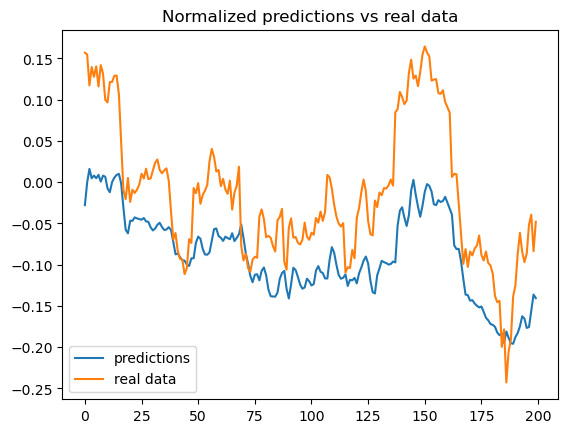

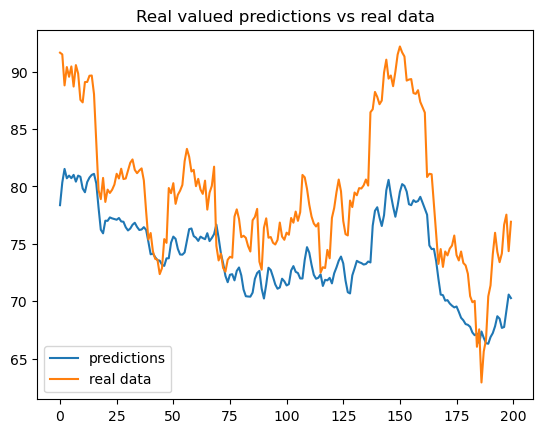

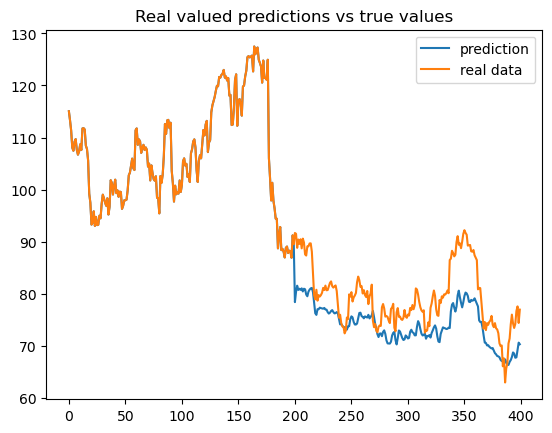

In [109]:
predictions_normalized = generate_predictions(cross_attention_gru_reg, window_step_length*2, data_values, num_of_future_predictions=num_test_points)
print(predictions_normalized)
plot_pred_vs_real(predictions_normalized, data_values, target_idx)